## Installing Dependencies

In [3]:
# pip install --user -U scikit-learn scipy matplotlib wordcloud nltk numpy

  Using cached scikit_learn-1.2.0-cp39-cp39-win_amd64.whl (8.3 MB)
  Using cached scipy-1.9.3-cp39-cp39-win_amd64.whl (40.2 MB)
  Using cached matplotlib-3.6.2-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached wordcloud-1.8.2.2-cp39-cp39-win_amd64.whl (153 kB)
  Using cached nltk-3.8-py3-none-any.whl (1.5 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached contourpy-1.0.6-cp39-cp39-win_amd64.whl (161 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Import Dependencies

In [3]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# natural language toolkit
import nltk
from nltk.stem import WordNetLemmatizer

# sklean
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# one time downloads
#nltk.download('wordnet')
#nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...


True

## Import Dataset
The dataset being used is a sample Twitter dataset containing tweets extracted using **Twitter API**.  The tweets have been annotated **(0 = Negative, 4 = Positive)** and can be used to detect sentiment.  
**It contains the following 6 fields:**<br>
1. **sentiment**: Polarity of tweet (0 = negative, 4 = positive)
2. **id**'s: the id of the tweet
3. **date**: date of tweet in UTC
4. **flag**: the query (lyx).  If there is no query, the value is NO_QUERY
5. **user**: twitter handle of op
6. **text**: text of the tweet


We only require the **sentiment** and **text** fields, rest are discarded.  
We will also change **sentiment** field to new values where **0=negative, 1=positive**

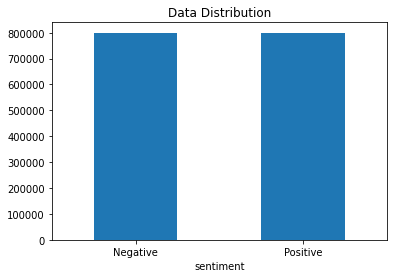

In [5]:
# Column Names
DATASET_COLUMNS = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../Sentiment_Analysis_Tweets_Data.csv',
                     encoding=DATASET_ENCODING,
                     names=DATASET_COLUMNS)
# Drop columns
dataset = dataset[['sentiment', 'text']]
# Replace sentiment values
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plot distribution
ax = dataset.groupby('sentiment').count().plot(kind='bar',
                                              title='Data Distribution',
                                              legend=False)
ax.set_xticklabels(['Negative','Positive'],
                  rotation=0)

# Sort data in lists
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## Preprocessing
**Steps taken are as follow**
1. **Lower Casing**: Convert each text to lowercase
2. **Replace URLs**: Link protocols are replaced with URL
3. **Replace Emojis**: Replace emojis using dictionary to text meaning such as :) to "EMOJIsmile"
4. **Replace Username**: Replace handles to "USER"
5. **Replace Non-Alphabets**: Replace characters except digits and alphabets with a space
6. **Remove Consecutive Lettrs**: 3 or more consecutive letters are replaced with 2 letters e.g. "heeeeyyyy" to "heeyy"
7. **Remove Short Words**: Words with length less than 2 are removed
8. **Remove Stopwords**: Stopwords are words that do not add meaning and can be ignored e.g. "the", "he", "have"
9. **Lemmatizing**: Lemmatization is process of converting word to base form e.g. "great" to "good"

In [7]:
# Define dictionary for emojis
emojis = {':)':'smile',':-)':'smile',';d':'wink',':-E':'vampire',':(':'sad',':-(':'sad',':-<':'sad',':p':'raspberry',
          ':O':'surprised',':-@':'shocked',':@':'shocked',':-$':'confused',':\\':'annoyed',':#':'mute',':X':'mute',
          ':^)':'smile',':-&':'confused','$_$':'greedy','@@':'eyeroll',':-!':'confused',':-D':'smile',':-0':'yell',
          'O.o':'confused','<(-_-)>':'robot','d[-_-]b':'dj',":'-)":'sadsmile',';)':'wink',';-)':'wink','O:-)':'smile',
          'O*-)':'angel','(:-D':'gossip','=^.^=':'cat'}

# Define set for stopwords in English
stopwordlist = ['a','about','above','after','again','ain','all','am','an','and','any','are','as','at','be','because',
                'been','before','being','below','between','both','by','can','d','did','do','does','doing','down','during',
                'each','few','for','from','further','had','has','have','having','he','her','here','into','is','it','its',
                'itself','just','ll','m','ma','me','more','most','my','myself','now','o','of','on','once','only','or','other',
                'our','ours','ourselves','out','own','re','s','same','she',"shes",'should',"shouldve",'so','some','such','t',
                'than','that',"thatll",'the','their','theirs','them','themselves','then','there','these','they','this','those',
                'through','to','too','under','until','up','ve','very','was','we','were','what','when','where','which','while',
                'who','whom','why','will','with','won','y','you',"youd","youll","youre","youve",'your','yours','yourself',
                'yourselves']

In [13]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer
    wordLemm = WordNetLemmatizer()
    
    # Define regest patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ])*"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace URLs with "URL"
        tweet = re.sub(urlPattern, ' URL', tweet)
        # Replace emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace usernames with "USER"
        tweet = re.sub(userPattern, ' USER', tweet)
        # Replace all non alphabets
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters with 2 lettters
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            # Check for stopwords if not in stopwordlist
            if len(word)>1:
                # Lemmatize
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
                
        processedText.append(tweetwords)
        
    return processedText
    

In [14]:
# Recordig process time
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time taken: 408 seconds


## Analyzing
Plotting **WordClouds** for **Positive and Negative** tweens from dataset and see frequency of words

### WordCloud for Negative Tweets

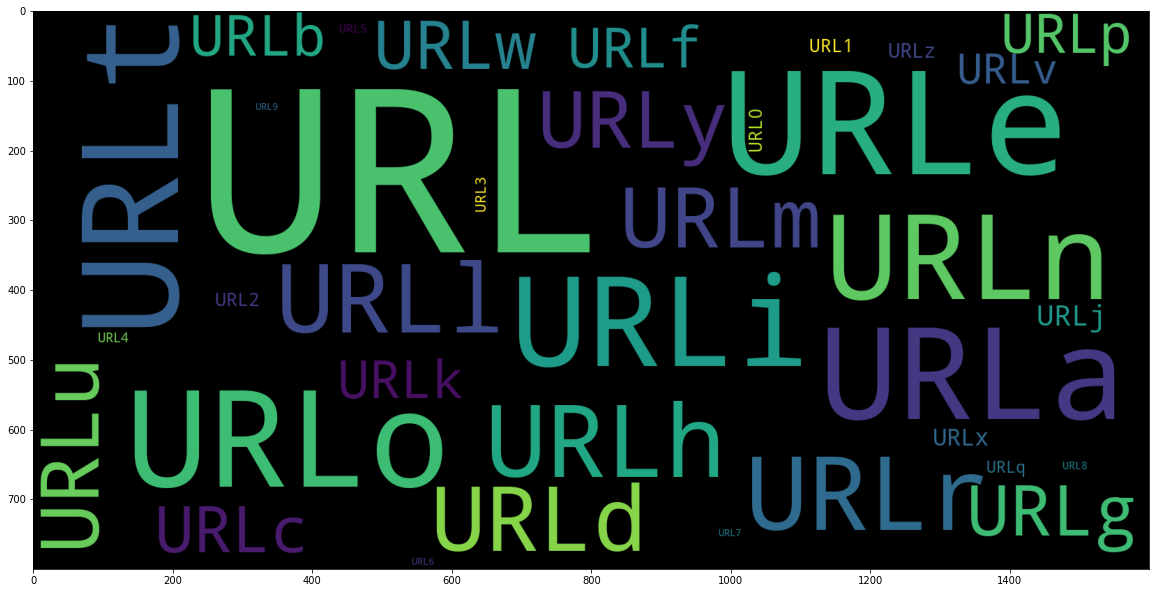

In [15]:
data_neg = processedtext[:80000]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000,
              width=1600,
              height=800,
              collocations=False).generate(" ".join(data_neg))
plt.imshow(wc);